Title

Introduction:
provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
clearly state the question you tried to answer with your project
identify and describe the dataset that was used to answer the question


**from proposal**
>* The data used originated from the Facebook metrics of a popular cosmetics brand. Based on this information, we want to know how successful each post type is based on its audience reach. We will base the sucess of each post by the total number of interactions (likes, comments, shares).
>* We have decided to use the total number of interactions on posts rather than the total amount of times a post has been consumed. This is to determine how much of each post type have the highest engagement/ active users. This is because the number of people viewing a specific post can be misleading because people could be accidently clicking on the post which still counts as 1 view. We want to see the actively viewing/participating users who actually intended on viewing the post. 
* Clearly state the question you will try to answer with your project
>* Which kind of post (link, photo, status or video) is most popular during each day?
In answering the above question we will also think about: which post type is most popular in general? Which day do people interact on facebook the most on?
* Identify and describe the dataset that will be used to answer the question
>* The data set used to answer the question is dataset_Facebook.csv. From the data, the x-axis is the "Total Interaction Count" while the y-axis is the "Weekday Posted." The fill of the bars is the type of post being interacted with. We will use this data to answer the question by finding what kind of post and which day to post is the most popular has the highest value.

**Methods & Results:**

>Loads the libraries and the data from the original source on the web.

In [248]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dbplyr)

In [249]:
activity_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip" #ICS Machine Learning Training set archive      
temp <- tempfile()                       #Vector of character strings to be used for naming temporary files, saved to temp.
download.file(activity_url, temp)        #Download Zip file from ICS archive, save into temp.
unzip(temp, "dataset_Facebook.csv")      #Unzip File.


fb_data <- read_delim("dataset_Facebook.csv",  #Read dataset and factor Type Column
                      ";") %>%                     
    mutate(Type = as.factor(Type))

# unlink(temp)                            #Delete Temporary Vector

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)




>The column names in the data are changes to exclude spaces and to replace them with "."
>The data is then wrangled and cleaned to include only relevant columns (Post.Weekday and Total.Interactions). These columns will be used for exploring the data.

In [251]:
#Tidying Data: Replace spaces in Column names with periods.
colnames(fb_data) <- make.names(colnames(fb_data))
    head(fb_data)

fb_data_eda <- fb_data %>%
    select(Type, Post.Weekday, Total.Interactions) 

Page.total.likes,Type,Category,Post.Month,Post.Weekday,Post.Hour,Paid,Lifetime.Post.Total.Reach,Lifetime.Post.Total.Impressions,Lifetime.Engaged.Users,Lifetime.Post.Consumers,Lifetime.Post.Consumptions,Lifetime.Post.Impressions.by.people.who.have.liked.your.Page,Lifetime.Post.reach.by.people.who.like.your.Page,Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post,comment,like,share,Total.Interactions
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
139441,Photo,2,12,2,3,0,7244,13594,671,410,580,6228,3200,396,19,325,49,393
139441,Status,2,12,1,9,0,10472,20849,1191,1073,1389,16034,7852,1016,1,152,33,186


>A visualization of the exploratory data analysis consisted of the weekday a post was posted and the total interactions it had. For the purposes of this section, interactions is defined as likes, comments, and shares. The visualization shows that Wednesday has the highest interaction count and that mainly photos are interacted with.

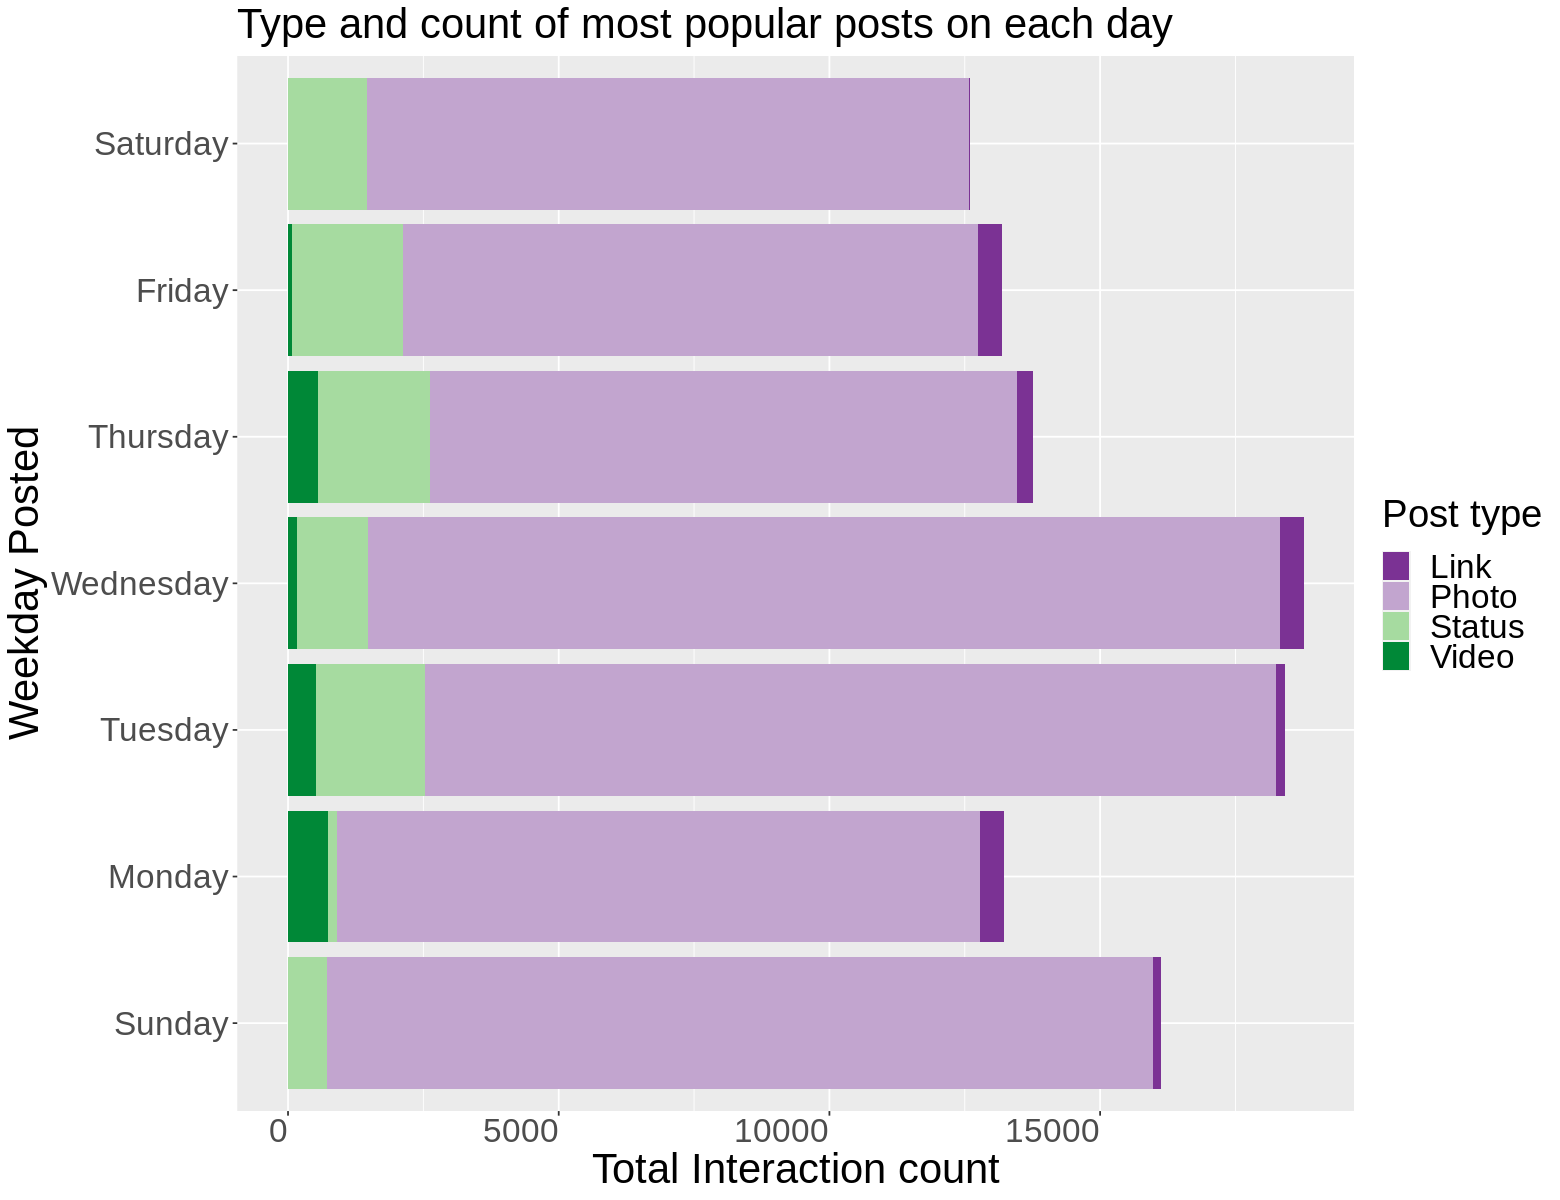

In [241]:
options(repr.plot.height = 10, repr.plot.width = 13)

most_interactions <- fb_data_eda %>%                                      #plot of interactions and post type vs day
    arrange(desc(Post.Weekday)) %>%
    ggplot(aes(x = Post.Weekday, 
                 y = Total.Interactions,                     
                 fill = Type)) + 
    geom_bar(stat = "identity") +                                     #graph titles
    xlab("Weekday Posted") +
    ylab("Total Interaction count") +
    labs(fill = "Post type") +
    ggtitle("Type and count of most popular posts on each day") +
    theme(axis.text = element_text(size = 20,                         #font sizes
                                    hjust = 1),
         plot.title = element_text(size = 25),
         axis.title = element_text(size = 25),
         legend.text = element_text(size = 20),
         legend.title = element_text(size = 23)) +
            scale_fill_brewer(palette = 'PRGn') +
 scale_x_discrete(limits=c("1", "2", "3", "4", "5", "6", "7"),
                  labels=c("1" = "Sunday",
                           "2" = "Monday",
                           "3" = "Tuesday",
                           "4" = "Wednesday",
                           "5" = "Thursday",
                           "6" = "Friday",
                           "7" = "Saturday" )) +
    coord_flip()
most_interactions

In [242]:
options(repr.plot.height = 10, repr.plot.width = 13)

fb_data <- fb_data %>%
    filter(Post.Weekday == "4") %>%
    select(Type, Lifetime.Post.Total.Impressions, like) ############

fb_recipe <- recipe(Lifetime.Post.Total.Impressions ~ like, ############
                    data = fb_data)

fb_recipe <- fb_recipe %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors()) %>%
  prep()

>Further analysis uses the amount of likes and the lifetime post total impressions. Impressions are the number of times a post is viewed, regardless if it is the same consumer. The visualization below shows that photos and links have the highest lifetime post toal impressions and likes.

<ggproto object: Class CoordFlip, CoordCartesian, Coord, gg>
    aspect: function
    backtransform_range: function
    clip: on
    default: FALSE
    distance: function
    expand: TRUE
    is_free: function
    is_linear: function
    labels: function
    limits: list
    modify_scales: function
    range: function
    render_axis_h: function
    render_axis_v: function
    render_bg: function
    render_fg: function
    setup_data: function
    setup_layout: function
    setup_panel_guides: function
    setup_panel_params: function
    setup_params: function
    train_panel_guides: function
    transform: function
    super:  <ggproto object: Class CoordFlip, CoordCartesian, Coord, gg>

Warning message:
“Removed 1 rows containing missing values (geom_point).”


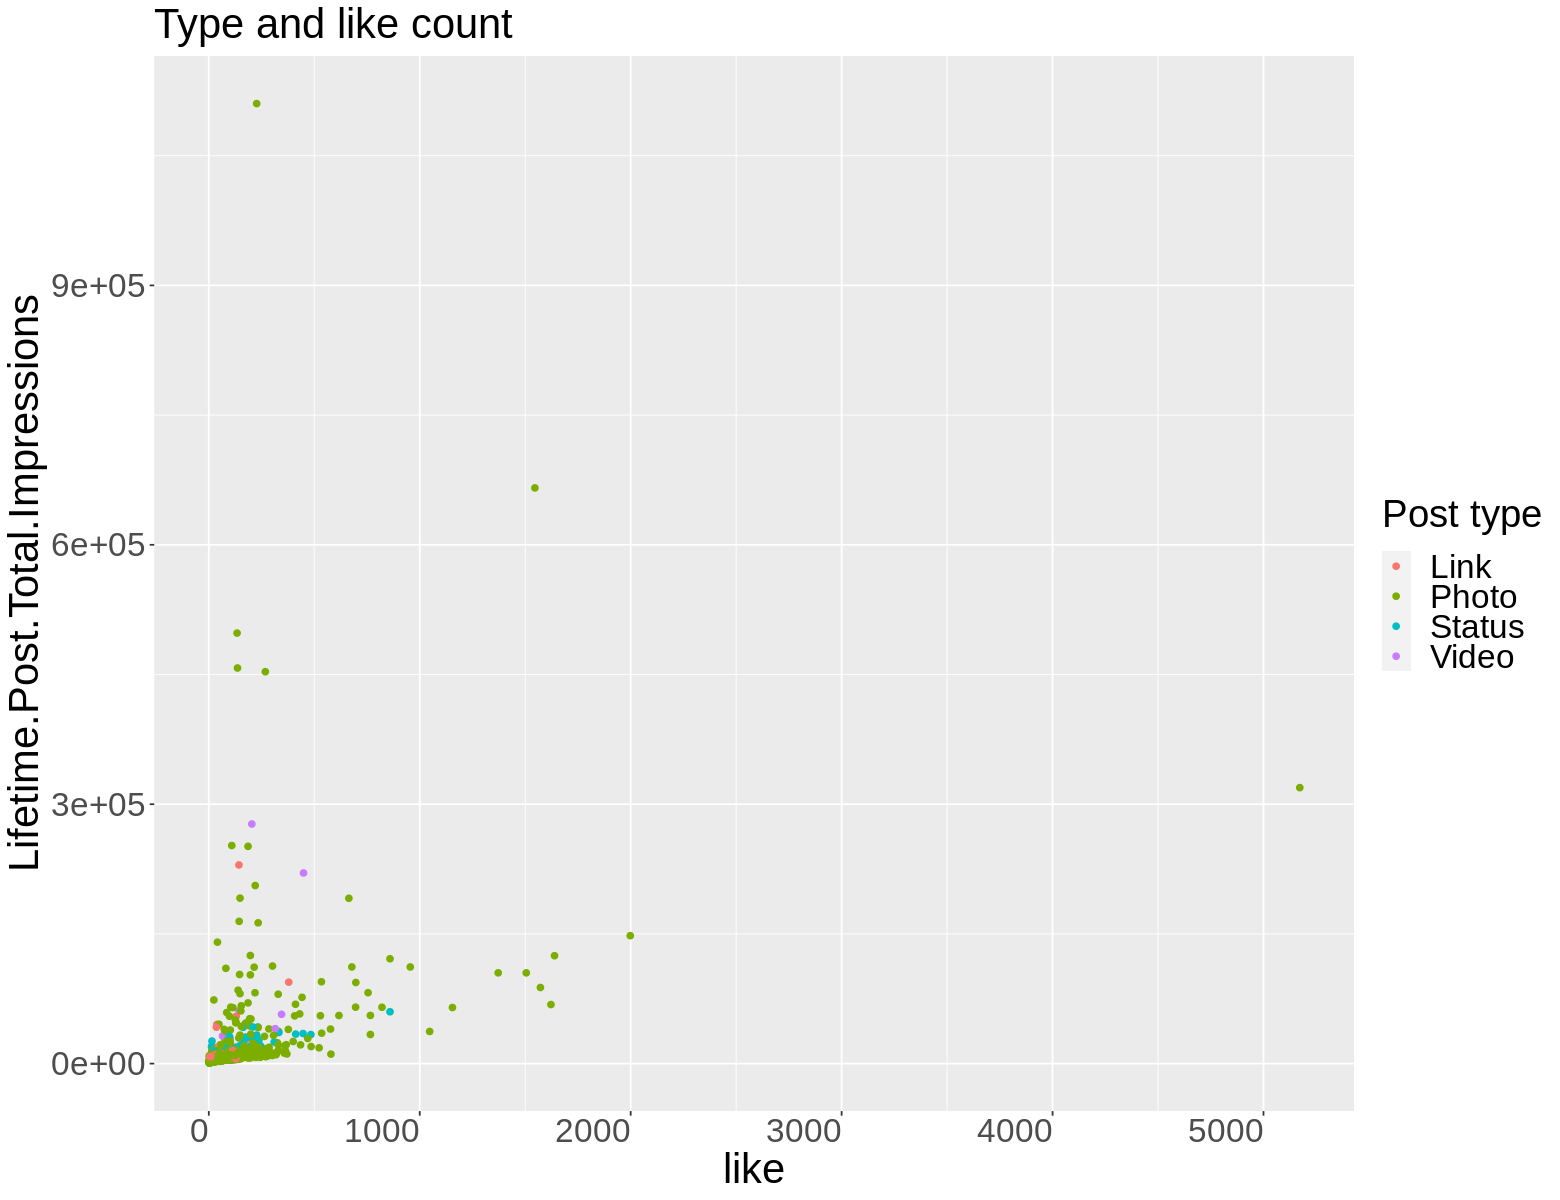

In [255]:
most_interactions <- fb_data %>%                                      #plot of interactions and post type vs day
    ggplot(aes(x = like, 
                 y = Lifetime.Post.Total.Impressions,                     
                 colour = Type)) + 
    geom_point() +                                     #graph titles
    ylab("Lifetime.Post.Total.Impressions") +
    xlab("like") +
    labs(colour = "Post type") +
    ggtitle("Type and like count") +
    theme(axis.text = element_text(size = 20,                         #font sizes
                                    hjust = 1),
         plot.title = element_text(size = 25),
         axis.title = element_text(size = 25),
         legend.text = element_text(size = 20),
         legend.title = element_text(size = 23)) +
            scale_fill_brewer(palette = 'PRGn') 
    coord_flip()
most_interactions

In [256]:
fb_split <- initial_split(fb_data,
                          prop = 0.75,
                          strata = Type)  #splitting data
fb_train <- training(fb_split)   
fb_test <- testing(fb_split)

head(fb_train)
head(fb_test)

Page.total.likes,Type,Category,Post.Month,Post.Weekday,Post.Hour,Paid,Lifetime.Post.Total.Reach,Lifetime.Post.Total.Impressions,Lifetime.Engaged.Users,Lifetime.Post.Consumers,Lifetime.Post.Consumptions,Lifetime.Post.Impressions.by.people.who.have.liked.your.Page,Lifetime.Post.reach.by.people.who.like.your.Page,Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post,comment,like,share,Total.Interactions
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
139441,Photo,2,12,2,3,0,7244,13594,671,410,580,6228,3200,396,19,325,49,393
139441,Status,2,12,1,9,0,10472,20849,1191,1073,1389,16034,7852,1016,1,152,33,186
139441,Photo,3,12,1,3,1,11692,19479,481,265,364,15432,9328,379,3,249,27,279


Page.total.likes,Type,Category,Post.Month,Post.Weekday,Post.Hour,Paid,Lifetime.Post.Total.Reach,Lifetime.Post.Total.Impressions,Lifetime.Engaged.Users,Lifetime.Post.Consumers,Lifetime.Post.Consumptions,Lifetime.Post.Impressions.by.people.who.have.liked.your.Page,Lifetime.Post.reach.by.people.who.like.your.Page,Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post,comment,like,share,Total.Interactions
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,3,12,6,10,0,4694,8668,280,183,250,4309,2324,199,3,113,26,142
138414,Link,1,12,7,10,0,3454,6853,118,104,130,6282,3100,106,0,16,2,18
138414,Status,2,12,6,10,0,8488,15294,1341,1270,1489,9684,5244,995,3,99,19,121
138895,Photo,2,12,5,3,0,9560,18264,973,559,885,9217,4748,621,36,523,63,622
138895,Photo,1,12,2,3,0,3766,7149,298,260,431,5782,2938,244,2,56,17,75


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)         like  
   15044.60        82.03  


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.494268e+04
rsq,standard,1.963304e-01
mae,standard,2.441599e+04


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


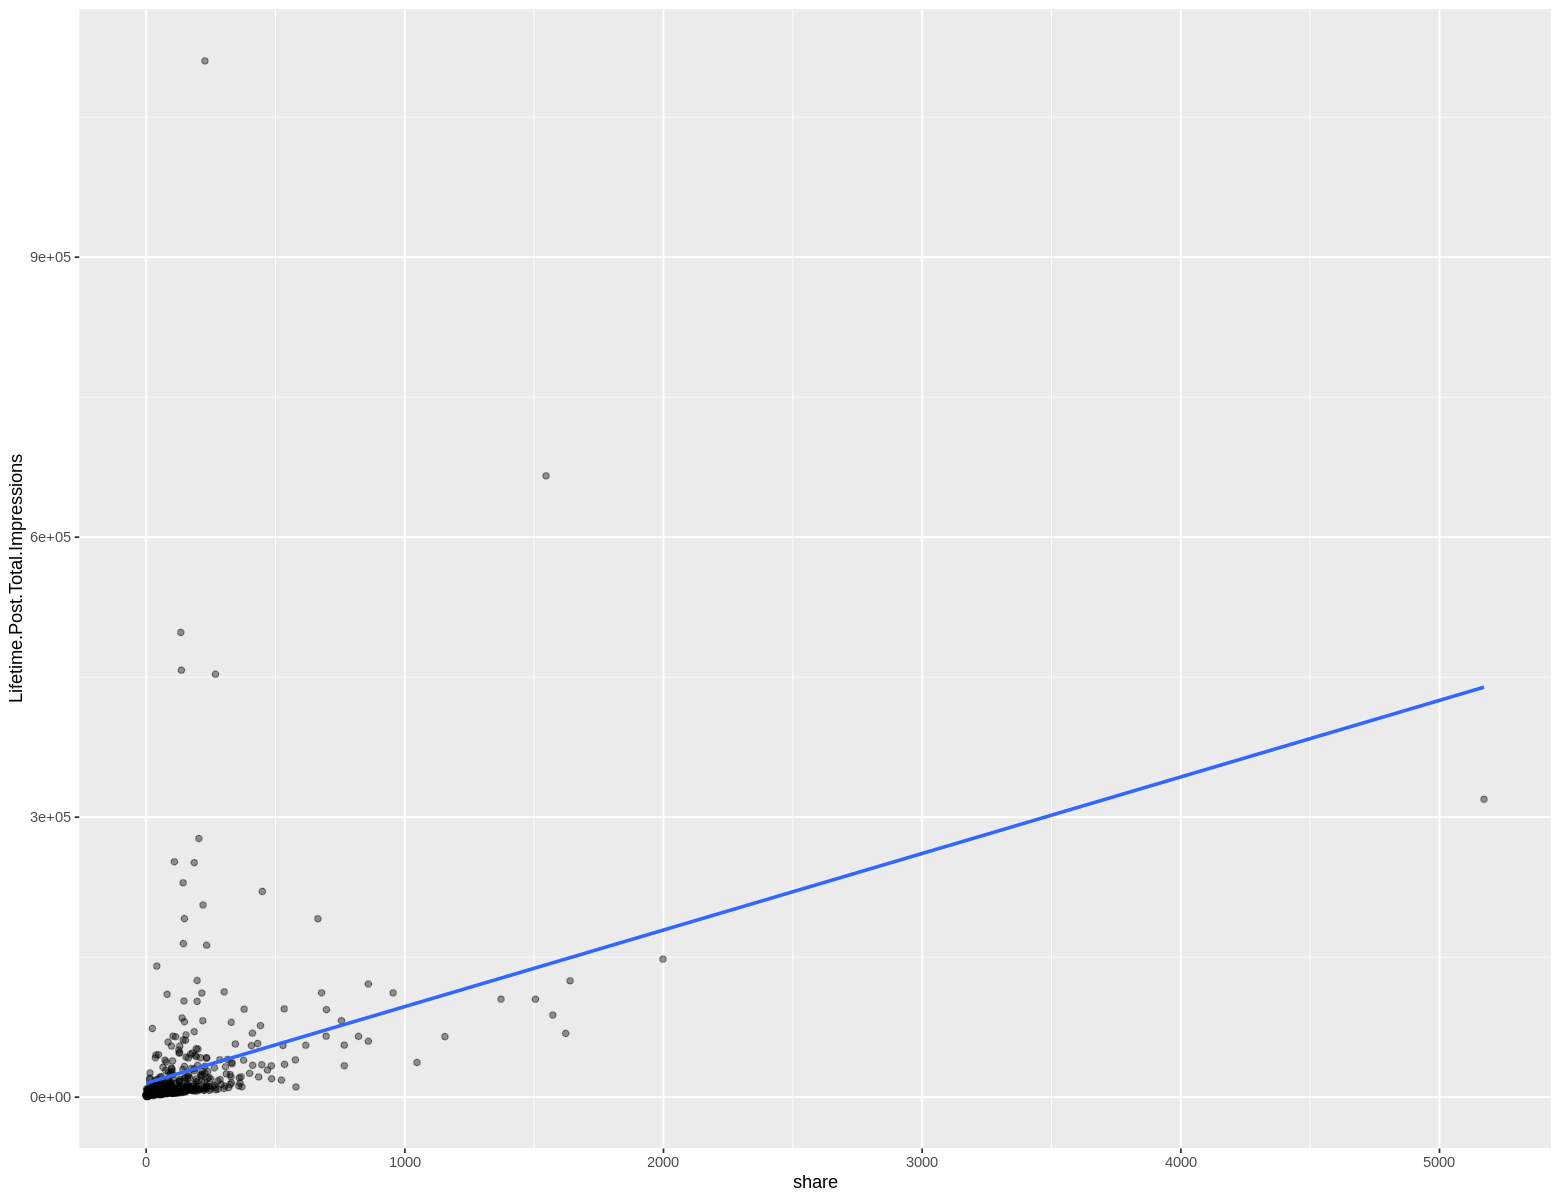

In [261]:
lm_spec <- linear_reg() %>%  
  set_engine("lm") %>%  
  set_mode("regression")

fb_recipe <- recipe(Lifetime.Post.Total.Impressions ~ like, ############
                    data = fb_data)

lm_fit <- workflow() %>%  
  add_recipe(fb_recipe) %>%  
  add_model(lm_spec) %>%  
  step_scale(all_predictors()) %>%
  step_center(all_predictors()) %>%
  fit(data = fb_data)
lm_fit

lm_test_results <- lm_fit %>%  
  predict(fb_test) %>%  
  bind_cols(fb_test) %>%  
  metrics(truth = Lifetime.Post.Total.Impressions,
          estimate = .pred)
lm_test_results

lm_plot_final <- ggplot(fb_data, aes(x = like,
                                     y = Lifetime.Post.Total.Impressions)) +
  geom_point(alpha = 0.4, aes(colour = T)) +
  xlab("share") +
  ylab("Lifetime.Post.Total.Impressions") +
  geom_smooth(method = "lm", se = FALSE)
lm_plot_final

For each

>creates a visualization of the analysis 
        note: all tables and figure should have a figure/table number and a legend

**from proposal**
>* We will conduct our data analysis by comparing the "Total Interaction Count" of each day which is divided and color-coded by the "Post Type."
>* We will use the Type, Total Interactions and Post Weekday columns as these will be useful in predicting which day and what type of post is most popular. 
* Describe at least one way that you will visualize the results
>* Color-coded bar graph with the x-axis being the "Total Interaction Count" (likes, shares, comments), and the y-axis as the "Weekday Posted." The "Post Type" being color-coded. 
>* Stacked bar graph with each color a different type of post(link, status, photo, video).

Discussion:
    summarize what you found
    discuss whether this is what you expected to find?
    discuss what impact could such findings have?
    discuss what future questions could this lead to?

References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.

Sources: (Moro et al., 2016) Moro, S., Rita, P., & Vala, B. (2016). Predicting social media performance metrics and evaluation of the impact on brand building: A data mining approach. Journal of Business Research, 69(9), 3341-3351.
